# Практикум по стохастическому анализу. Часть №2

Выполнил \
Пилюшенок Артур \
студент 415 группы ВМК МГУ

In [33]:
import numpy as np                              # matrix calculations
from matplotlib import pyplot as plt            # plotting
from time import time                           # calculation time
import sympy as sym                             # symbolic calculations

# empirical cumulative distribution function, distributions and quantiles
from scipy.stats import ecdf, norm, poisson, t, f, probplot, chi2

# for integral
from itertools import combinations_with_replacement
from scipy.special import factorial

In [34]:
def rand_expo(l, *args):
    '''
    Exponential distribution generator
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    return -np.log(np.random.rand(*args)) / l

In [35]:
def rand_norm(loc, scale, *args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns tensor with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return loc + scale * np.sqrt(omega) * np.cos(alpha)

def rand_norm_pair(*args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns pair of tensors with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return np.array((np.sqrt(omega) * np.cos(alpha), np.sqrt(omega) * np.sin(alpha)))

In [36]:
def rand_Cauchy(loc=0.0, scale=1.0, *args):
    '''
    Cauchy distribution generator
    returns tensor with given shapes
    loc - shift parameter
    scale - scale parameter, must be positive
    shapes error handling in rand_expo
    '''
    if not scale > 0:
        raise ValueError('Scale must be a positive float number.')
    return loc + scale * np.tan(np.pi * (np.random.rand(*args) - 0.5))

## Задание 7

### Условие
1. Методом случайного поиска найти минимальное значение функции $f$ на множестве $A = \{(x_1,x_2):~x_1^2+x_2^2\leqslant 1\}$, где
$$
f(x_1,x_2) = x_1^3\sin\frac{1}{x_1} + 10x_1x_2^4\cos\frac{1}{x_2},\quad x_1,x_2\neq0.
$$
При $x_1=0$ или $x_2=0$ функция доопределяется по непрерывности.

2. Методом имитации отжига найти минимальное значение функции Розенброка $g$ в пространстве $\mathbb{R}^2$, где
$$
g(x) = (x_1-1)^2 + 100(x_2-x_1^2)^2.
$$

3. Оценить точность и сравнить результаты со стандартными методами оптимизации.

### Метод случайного поиска

Метод случайного поиска минимального значения функции $f(x)$ на множестве $A$:
1. Смоделировать выборку размера $n$ точек $x\sim\mathrm{U}\{A\}$ (равномерно распределены на множестве A)
2. Выбрать ту реализацию случайной величины, на которой достигается наименьшее значение.

По условию задачи множество $A$ - круг единичного радиуса на плоскости $(x_1,x_2)$. Пусть $x=(x_1,x_2)\sim\mathrm{U}(A)$. По определению для любого борелевского множества $M$ выполняется ($\mu$ - мера Лебега на плоскости)
$$
\mathbb{P}\left( (x_1,x_2)\in M \right) = \dfrac{\mu (M)}{\mu (A)} = \dfrac{1}{\pi}\iint\limits_M dt_1dt_2 = \begin{vmatrix}
t_1 = r\cos\alpha \
t_2 = r\sin\alpha
\end{vmatrix} = \dfrac{1}{\pi}\iint\limits_M rdrd\alpha = \iint\limits_M d(r^2)d\left(\frac{\alpha}{2\pi}\right).
$$

Следовательно, будем моделировать
$$
\begin{cases}
x_1 = \sqrt{\omega}\cos\alpha \\
x_2 = \sqrt{\omega}\sin\alpha
\end{cases}
$$
где $\omega\sim\mathrm{U}[0,1], \alpha\sim\mathrm{U}[0,2\pi]$.


Данная функция $f(x)=x_1^3\sin\frac{1}{x_1}+10x_1x_2^4\cos\frac{1}{x_2}$ обладает свойствами 
1. $f(x_1,-x_2)=f(x_1,x_2)$ (чётность по $x_2$)
2. $f(-x_1,0)=f(x_1,0)=x_1^3\sin\frac{1}{x_1}$
3. $f(0,0)=0$

Следовательно, если $x^*=(x_1^*,x_2^*)$ доставляет минимум функции, то $(x_1^*,-x_2^*)$ также доставляет минимум. \
Минимум меньше нуля, ведь $f(0.1, 0.1) < 0$ (проверяется численно). \
Следовательно, функция $f$ имеет хотя бы две точки глобального минимума.

Отметим, что при реализации метода случайного поиска значения $x_1=0, x_2=0$ достигаются с нулевой вероятностью. Следовательно, при вычислении значения заданной функции в точках выборки можно не обрабатывать неопределенность.

<!-- Пусть $\varepsilon>0$ - наперед заданная точность вычислений.  -->
Пусть $x^*=(x_1^*,x_2^*)$ доставляет минимум функции $f(x_1,x_2)$. \
Оценим точность работы алгоритма при помощи многомерной теоремы Лагранжа
$$
|f(x) - f(x^*)| \leqslant \max\limits_A 
\sqrt{\left(\dfrac{\partial f}{\partial x_1}\right)^2 + \left(\dfrac{\partial f}{\partial x_2}\right)^2} \cdot || x - x^* ||.
$$

Справедливы следующие оценки
$$
\begin{aligned}
\left|\dfrac{\partial f}{\partial x_1}\right| &= \left| 3x_1^2\sin\frac{1}{x_1} - x_1\cos\frac{1}{x_1} + 10x_2^4\cos\frac{1}{x_2}  \right| \leqslant 14. \\
\left|\dfrac{\partial f}{\partial x_2}\right| &= \left| 40x_1x_2^3\cos\frac{1}{x_2} + 10x_1x_2^2\sin\frac{1}{x_2} \right| \leqslant 50.
\end{aligned}
$$

Далее выберем окрестность радиуса $\delta\in(0,1)$: $B_\delta(x^*)=\{ x: ||x-x^*||\leqslant \delta \}$. \
Пусть $p$ - вероятность того, что в $B_\delta(x^*) \cap A$ находится хотя бы одна точка выборки $(x_1,x_2,\dots,x_n)$.
$$
p = \mathbb{P}(\exists k:~||x_k-x||\leqslant\delta) = 1 - \mathbb{P}(\forall k~ ||x_k-x^*||>\delta) = 1 - \prod_{k=1}^n\mathbb{P}(||x_k-x^*||>\delta).
$$

Если $B_\delta(x^*) \cap A = B_\delta(x^*)$, вероятность в правой части полученного выражения можно вычислить как отношение соответствующих площадей:
$$
\mathbb{P}(||x_k-x^*||>\delta) = \dfrac{\pi - \pi\delta^2}{\pi} = 1 - \delta^2 < 1 - \frac{\delta^2}{2}.
$$
Если $B_\delta(x^*) \cap A \neq B_\delta(x^*)$, то ограничим вероятность сверху числом $1-\frac{\delta^2}{2}$. Этот случай включает в себя возможное расположение точки $x^*$ на границе единичного круга. Ясно, что в худшем случае половина окрестности не будет лежать в круге.

Таким образом
$$
1-p = \prod_{k=1}^n\mathbb{P}(||x_k-x^*||>\delta) < \left(1-\frac{\delta^2}{2}\right)^n.
$$
Зафиксируем $p, \delta$. Тогда с вероятностью $p$ в окрестности радиуса $\delta$ искомого решения будет находиться элемент выборки, если размер выборки составляет
$$
n = \bigg\lfloor\dfrac{\ln(1-p)}{\ln\left(1-\frac{\delta^2}{2}\right)}\bigg\rfloor.
$$

Если выбрать $x\in B_\delta(x^*)$ погрешность вычисления составит
$$
|f(x) - f(x^*)| \leqslant \sqrt{14^2 + 50^2}\cdot\delta = \varepsilon.
$$
Таким образом, по заданным $\varepsilon$ - погрешности вычисления и $p$ - уровне доверия, можно вычислить $\delta, n$.

In [37]:
def func(x1, x2):
    return x1 ** 3 * np.sin(1 / x1) + 10 * x1 * x2 ** 4 * np.cos(1 / x2)

def min_random_search(func, eps, p):
    delta = eps / np.sqrt(2696)
    n_points = np.floor(np.log(1 - p) / np.log(1 - delta**2 / 2)).astype(int)
    omega_sample = np.random.rand(n_points)
    alpha_sample = np.random.rand(n_points) * 2 * np.pi
    x1 = np.sqrt(omega_sample) * np.cos(alpha_sample)
    x2 = np.sqrt(omega_sample) * np.sin(alpha_sample)
    f_min = np.min(func(x1, x2))
    i_min = np.argmin(func(x1, x2))
    return f_min, [x1[i_min], x2[i_min]], n_points


print(f"f(0.1,0.1) = {func(0.1,0.1):.4f} < 0.")

eps = 0.05
p = 0.99
val, point, n_points = min_random_search(func, eps, p)
print(f"f*({point[0]:.8f},{point[1]:.8f})= {val:.8f} obtained by sample of {n_points} points.")

f(0.1,0.1) = -0.0006 < 0.
f*(-0.35390594,-0.93527646)= -1.28829337 obtained by sample of 9932428 points.


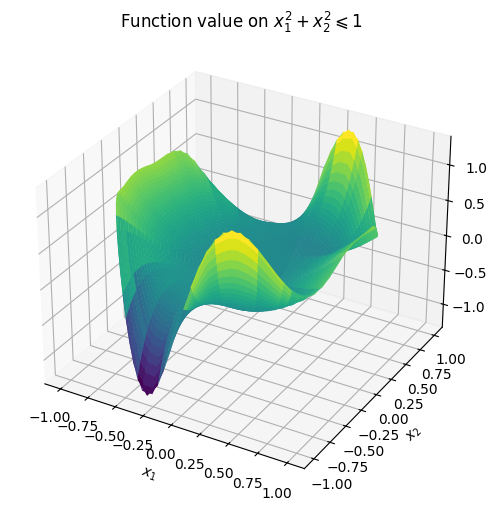

In [38]:
n_points = 100
r = np.linspace(0.001, 1, n_points)
alpha = np.linspace(-2*np.pi, 2*np.pi, n_points)
r, alpha = np.meshgrid(r, alpha)

X = r * np.sin(alpha)
Y = r * np.cos(alpha)
Z = func(X, Y)

plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('Function value on $x_1^2+x_2^2\leqslant1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Метод имитации отжига

In [39]:
def func_Rosenbrock(x):
    return (x[0] - 1)**2 + 100 * (x[1] - x[0]**2)**2

def choose_neighbour(s_i, T_i, sigma):
    pair = rand_norm_pair()
    return s_i + np.sqrt(sigma) * T_i * pair

def transfer_probability(d_F_i, T_i):
    return np.exp(-d_F_i * T_i)

def reduce_temperature(T_i, k):
    return k * T_i

def min_simulated_annealing(sigma,
                            k,
                            s_0,
                            T_0,
                            iter_count,
                            func,
                            choose_neighbour,
                            transfer_probability,
                            reduce_temperature):
    # always transfer at first step

    func_last = func(s_0)
    func_min = func_last
    point_min = s_0

    s_i = choose_neighbour(s_0, T_0, sigma)
    T_i = reduce_temperature(T_0, k)

    # other steps
    for i in range(iter_count):
        func_value = func(s_i)
        print(func_value)
        if func_value < func_min:
            func_min = func_value
            point_min = s_i
        transfer = transfer_probability(func_value - func_last, T_i)
        if np.random.rand() < transfer:
            s_i = choose_neighbour(s_i, T_i, sigma)
        T_i = reduce_temperature(T_i, k)

    return func_min, point_min


val, point = min_simulated_annealing(5,
                                    0.79,
                                    [1.5, 1.5],
                                    1,
                                    10000,
                                    func_Rosenbrock,
                                    choose_neighbour,
                                    transfer_probability,
                                    reduce_temperature)
print(val, point)

# T = 0.01

# s_i = [0.5, 0.5]
# T_i = T
# func_last = np.inf
# iter_count = 1000

# for i in range(iter_count):
#     func_value = func_Rosenbrock(s_i)
#     transfer = transfer_probability(func_value - func_last, T_i)
#     if np.random.rand() < transfer:
#         s_i = choose_neighbour(s_i, T_i)
#     T_i = reduce_temperature(T_i)
#     func_last = np.min([func_value, func_last])

# func_last, s_i

338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
338.1137360132352
341.263961248926
341.263961248926
341.263961248926
339.4825289215553
339.4825289215553
339.61791875440997
340.2182894391872
340.2182894391872
340.04081953155185
340.04081953155185
339.5169347194704
339.5169347194704
339.7090126332718
339.6278842090473
339.53941595758334
339.5984918774793
339.4818295700254
339.49046747757717
339.46671744331303
339.50092516972995
339.4969807695219
339.49068007978866
339.5019274603592
339.4995723557838
339.4942202468712
339.4977707450987
339.4866890083005
339.48357684211527
339.48743894806967
339.49106595434
339.49536321272853
339.

### Сравнение методов

## Задание 8

### Условие
1. Применить метод Монте-Карло к решению первой краевой задачи для двумерного уравнения Лапласа в единичном круге
$$
\begin{cases}
\Delta u = 0,(x,y)\in D \
u\vert_{\delta D} = f(x,y) \\
u\in C^2(D), f\in C(\delta D) \\
D=\{(x,y)\in\mathbb{R}^2: x^2+y^2\leqslant 1 \}
\end{cases}
$$

2. Для функции $f(x,y) = x^2-y^2$ найти аналитическое решение и сравнить с полученным по методу Монте-Карло.

### Метод Монте-Карло для уравнения Лапласа

<!-- Будем решать задачу не в единичном круге, а в единичном квадрате. Решение при этом не изменится, ведь ($x^2-y^2$) - единственное решение поставленной задачи в единичном круге, которое является непрерывным. После работы алгоритма выберем только те точки, которые лежат в единичном круге. -->

<!-- Введём сетку на единичном квадрате $|x|\leqslant1, |y|\leqslant1$. -->

Введём равномерную квадратную сетку в единичном круге с шагом $h$. Пусть $P(x_i,y_i)$ - узел, внутренняя точка сетки (имеет 4 соседа), $Q(\tilde{x}_i,\tilde{y}_i)$ - граничная точка сетки. \
Рассмотрим соответствующую теоретико-вероятностную схему. \
Будем искать вероятность $u(P,Q)$, того, что выйдя из внутренней точки $P$, будет достигнута граничная точка $Q$. \
Считаем, что все соседи выбираются равновероятным образом. Тогда для соседних точек $P_i,i=\overline{1,4}$ по отношению к $P$ справедливо
$$
u(P,Q) = \dfrac{1}{4}\left( u(P_1,Q) + u(P_2, Q) + u(P_3, Q) + u(P_4, Q) \right).
$$

Таким образом, мы пришли к конечноразностному уравнению, которое является конечно-разностной схемой для уравнения Лапласа:
$$
u(P) = \dfrac{1}{4}\left( u(P_1) + u(P_2) + u(P_3) + u(P_4) \right),
$$
где $P$ - внутренняя, $P_i,i=\overline{1,4}$ - соседние по отношению к $P$.

Вероятности $u(P,Q)$ можно вычислять приближенно: будем моделировать $N$ раз "блуждание" из точки $P$ в точку $Q$ и считать число $M(Q)$ испытаний, при которых "блуждание" оканчивается в точке $Q$:
$$
u(P,Q)\approx \frac{M(Q)}{N}.
$$

Чтобы решить поставленную задачу Дирихле, нужно немного обобщить полученную вероятностную схему. Нужно считать, что при выходе из узла $P$ и дальнейшем посещении граничной точки $Q$ с нас взымается штраф, равный $f(Q)$. Ясно, что величина выплаченного штрафа является случайной величиной. Обозначим её $\xi(P)$.

Пусть $\{Q_1,\dots,Q_s\}$ - совокупность всех граничных точек.
Тогда величина штрафа принимает значения $\{f(Q_1),\dots,f(Q_s)\}$, вероятность заплатить $f(Q_l)$ равняется $u(P,Q_l)$.
Значит, математическое ожидание штрафа определяется как:
$$
w(P) = \mathbb{E}\xi(P) = \sum_{l=1}^{s}f(Q_l)u(P,Q_l).
$$
Причем, $P(P)$ удовлетворяет разностному уравнению
$$
P(P) = \dfrac{1}{4}\left( w(P_1) + w(P_2) + w(P_3) + w(P_4) \right).
$$
Это непосредственно проверяется из исходной конечно-разностной схемы для уравения Лапласа при $Q=Q_l$ и суммировании обеих частей уравнений.

Таким образом, $w(P)$ принимает на границе заданные значения, является решением задачи Дирихле.

Дополнительные сведения можно найти в [1], стр. 117.

In [40]:
import itertools

def solve_Laplace(func, n_points, n_tests):

    def find_nearest():
        pass

    carthesian_grid = list(itertools.product(np.linspace(-1, 1, n_points), repeat=2))


n_points = 10 + 1
# step = 
carthesian_grid = list(itertools.product(np.linspace(-1, 1, n_points), repeat=2))

# for point in test:
#     x, y = point
#     if (abs(x) == 1 or abs(y) == 1):
#         continue
    

### Сравнение численного результата с аналитическим решением

Функция $f(x,y)=x^2-y^2$ удовлетворяет $\Delta u=0$. Для внешней задачи Дирихле условием регулярности является ограниченность функции $u$. Функция $f=u$ является ограниченной, следовательно, данное уравнение имеет единственное решение, равное $x^2-y^2$.

## Задание 9

### Условие

Рассмотреть два вида гауссовских процессов:

- Винеровский процесс $W(t), t\in[0,1], W(0)=0$.

- Процесс Орнштейна-Уленбека $X(t), t\in[0,1], X(0)=X_0$, т.е. стационарный марковский гауссовский процесс. Начальные значения $X_0$ следует выбирать случайным образом так, чтобы полученный процесс был стационарным.

Для данных процессов:

1. Найти ковариационную функцию и переходные вероятности.

2. Промоделировать независимые траектории процесса с данными переходными вероятностями методом добавления разбиения отрезка.

3. Построить график траектории, не соединяя точки ломаной, с целью получения визуально непрерывной линии.

### Теоретические выкладки

__Опр.__ Рассмотрим вероятностное пространство $(\Omega,\mathcal{F},\mathbb{P})$. Случайный процесс - параметризованное семейство случайных величин $\{P_t\}_{t\in T}$, определенных на одном вероятностном пространстве, вида
$$
P_t: \Omega\mapsto \mathbb{R}\quad\forall t\in T,\quad T\subset[0,+\infty).
$$

__Опр.__ Случайный процесс $P_t$ имеет независимые приращения, если $\forall 0<t_0<t_1<t_2<\cdots<t_{n-1}<t_n,~ t_i\in T,i=\overline{0,n}$ случайные величины $P_{t_0}, P_{t_1}-P_{t_0}, P_{t_2}-P_{t_1}, \dots, P_{t_n}-P_{t_{n-1}}$ являются независимыми.

__Опр.__ Случайный процесс $P_t$ является гауссовским, если $\forall 0<t_0<t_1<t_2<\cdots<t_{n-1}<t_n,~ t_i\in T,i=\overline{0,n}$ случайный вектор $(P_{t_0},P_{t_1},\dots,P_{t_n})$ имеет многомерное нормальное распределение.

__Опр.__ Случайный процесс $P_t$ является стационарным (в узком смысле), если его конечномерные распределения инвариантны относительно сдвига по времени.

<!-- __Опр.__ Винеровский процесс $W_t,t\in[0,1]$ - это гауссовский процесс со средним 0 и ковариационной функцией $\operatorname{cov}(W_t,W_s) = \min\{t,s\}$. -->

__Опр.__ Винеровский процесс $W_t,t\in T$ - это случайный процесс, обладающий следующими свойствами:
1. $W_0 = 0$ п.н.
2. $W_t$ имеет независимые приращения.
3. $W_t-W_s \sim \mathcal{N}(0, \sigma^2(t-s))$, где $\sigma>0$ и $\forall~s,t\in T:0\leqslant s<t$.

__Опр.__ Процесс Орнштейна-Уленбека $X_t,t\in[0,1]$ - это единственный нетривиальный стационарный марковский гауссовский процесс.

Пусть $P_t$ - случайный процесс. Обозначим
$$
R_P(t_1, t_2) = \operatorname{cov}(P_{t_1},P_{t_2}) = \mathbb{E}[(P_{t_1}-\mathbb{E}P_{t_1})(P_{t_2}-\mathbb{E}P_{t_2})].
$$

Далее вычислим $R_W(\cdot,\cdot), R_X(\cdot,\cdot)$.

__Теорема__ Случайный процесс $\{P_t\}_{t\in T}$ является марковским тогда, и только тогда, когда
$$
\widetilde{R}_P(s,t) = \widetilde{R}_P(s,\tau)\cdot\widetilde{R}_P(\tau,t),\quad\forall s<\tau<t \in T,
$$
где $\widetilde{R}_P(s,t)=\frac{R_P(s,t)}{\sqrt{\mathbb{D}P_s\mathbb{D}P_t}}$ - коэффициент корреляции между $P_s,P_t$.

Доказательство приведено в [3], стр. 123-128.

__Теорема__ Пусть функция $u(t)$ определена при $t>0$ и ограничена в каждом конечном интервале. Если $u(t)$ удовлетворяет функциональному уравнению Коши
$$
u(t+s)=u(t)u(s),
$$
то или $u(t)=0$ при всех $t$, или найдется такая постоянная $\theta>0$, что $u=e^{-\theta t}$.

Доказательство приведено в [2], стр. 444.

Пусть требуется смоделировать случайный процесс $X_t$ на отрезке $[0,1]$. Метод разбиения отрезка:
1. Моделирование $X_0$.
2. Моделирование $X_1$ по условному распределению $X_1|X_0$.
3. Пусть $t_1,t_2$ - крайние узлы сетки, $t_3=\frac{t_1+t_2}{2}$. Моделируем $X_{t_3}$ по условному распределению $X_t|X_{t_1}=x_1,X_{t_2}=x_2$.
4. Повторяем шаг 3 до достижения заданного шага разбиения.

### Решение для винеровского процесса

Из определения винеровского процесса следует
$$
W_t \sim \mathcal{N}(0,\sigma^2 t).
$$
Следовательно, $W_1\sim\mathcal{N}(0,\sigma^2)$.

Вычислим $R_W(\cdot,\cdot)$: пусть $0\leqslant t_1<t_2$, тогда
$$
\begin{aligned}
R_W(t_1,t_2) &= \operatorname{cov}(W_{t_1},W_{t_2}) = \mathbb{E}[ W_{t_1}W_{t_2} ] = \mathbb{E}[ W_{t_1}(W_{t_2}-W_{t_1}+W_{t_1}) ] = \\
&= \{\text{линейность мат. ожидания, независимость }W_{t_2}-W_{t_1}\text{ и }W_{t_1} \} = \\
&= \mathbb{E}[ W_{t_1} ]\cdot \mathbb{E}[ W_{t_2}-W_{t_1} ] + \mathbb{E}W_{t_1}^2 = \\
&= \sigma^2t_1.
\end{aligned}
$$
Вычисления в случае $0\leqslant t_2<t_1$ аналогичны.

Таким образом,
$$
R_W(t_1,t_2) = \sigma^2 \min\{ t_1,t_2 \}.
$$

Далее считаем $0\leqslant t_1<t_2$. Нас интересует распределение $Y = W_{t_3}|W_{t_1}=\omega_1,W_{t_2}=x_2$, где $t_3\in(t_1,t_2)$.

Мы могли бы найти распределение $Y$ для любого $t_3$ из интервала, но для реализации метода добавления разбиения отрезка нам достаточно знать распределение $Y$ при $t_3 = \frac{t_1+t_2}{2}$.

Обозначим плотность $Y$ как $p_Y(\omega;\omega_1,\omega_2)$. Тогда
$$
p_Y(\omega;\omega_1,\omega_2) = p_{W_{t_3}}(\omega~|~W_{t_1}=\omega_1,W_{t_2}=\omega_2) = \dfrac{p_{(W_{t_1},W_{t_3},W_{t_2})}(\omega_1,\omega,\omega_2)}{p_{(W_{t_1},W_{t_2})}(\omega_1,\omega_2)},
$$
где $p_{(W_{t_1},W_{t_3},W_{t_2})}$ и $p_{(W_{t_1},W_{t_2})}$ - плотности векторов $(W_{t_1},W_{t_3},W_{t_2})$ и $(W_{t_1},W_{t_2})$ соответственно.

Плотность многомерного нормального распределения с вектором средних $\mu\in\mathbb{R}^n$ и ковариационной матрицей $\Sigma\in\mathbb{R}^{n\times n}$ имеет вид
$$
p(x_1,x_2,\dots,x_n) = \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}}\exp\left\{ -\dfrac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T \right\}.
$$

Обозначим
$$
\Sigma_{12} = \{R_W(t_i,t_j) \}_{i,j=1,2} = \sigma^2\begin{pmatrix}
t_1 & t_1 \\
t_1 & t_2
\end{pmatrix}, \qquad
\Sigma_{132} = \sigma^2\begin{pmatrix}
t_1 & t_1 & t_1 \\
t_1 & t_3 & t_3 \\
t_1 & t_3 & t_2
\end{pmatrix}
$$

Следовательно,
$$
p_{(W_{t_1},W_{t_3},W_{t_2})}(\omega_1,\omega,\omega_2) = \dfrac{1}{\sqrt{(2\pi)^3|\Sigma_{132}|}}
\exp\left\{ -\dfrac{1}{2} (\omega_1,\omega,\omega_2)\Sigma_{132}^{-1}(\omega_1,\omega,\omega_2)^T \right\}. \\
p_{(W_{t_1},W_{t_2})}(\omega_1,\omega_2) = \dfrac{1}{\sqrt{(2\pi)^2|\Sigma_{12}|}}
\exp\left\{ -\dfrac{1}{2}(\omega_1,\omega_2)\Sigma_{12}^{-1}(\omega_1,\omega_2)^T \right\}.
$$

<!-- Таким образом,
$$
% p_Y(\omega;\omega_1,\omega_2) = \frac{- \omega^{2} t_{1}^{2} + 2 \omega^{2} t_{1} t_{2} - \omega^{2} t_{2}^{2} - 2 \omega \omega_{1} t_{1} t_{2} + 2 \omega \omega_{1} t_{1} t_{3} + 2 \omega \omega_{1} t_{2}^{2} - 2 \omega \omega_{1} t_{2} t_{3} + 2 \omega \omega_{2} t_{1}^{2} - 2 \omega \omega_{2} t_{1} t_{2} - 2 \omega \omega_{2} t_{1} t_{3} + 2 \omega \omega_{2} t_{2} t_{3} - \omega_{1}^{2} t_{2}^{2} + 2 \omega_{1}^{2} t_{2} t_{3} - \omega_{1}^{2} t_{3}^{2} + 2 \omega_{1} \omega_{2} t_{1} t_{2} - 2 \omega_{1} \omega_{2} t_{1} t_{3} - 2 \omega_{1} \omega_{2} t_{2} t_{3} + 2 \omega_{1} \omega_{2} t_{3}^{2} - \omega_{2}^{2} t_{1}^{2} + 2 \omega_{2}^{2} t_{1} t_{3} - \omega_{2}^{2} t_{3}^{2}}{2 \sigma^{2} t_{1}^{2} t_{2} - 2 \sigma^{2} t_{1}^{2} t_{3} - 2 \sigma^{2} t_{1} t_{2}^{2} + 2 \sigma^{2} t_{1} t_{3}^{2} + 2 \sigma^{2} t_{2}^{2} t_{3} - 2 \sigma^{2} t_{2} t_{3}^{2}}
p_Y(\omega;\omega_1,\omega_2) = \sqrt{\dfrac{t_1-t_2}{2\pi\sigma^2\left(t_{1} t_{2} - t_{1} t_{3} - t_{2} t_{3} + t_{3}^{2}\right)}}\cdot \\
\cdot \exp
\left\{ 
\frac{- \omega^{2} t_{1}^{2} + \omega^{2} t_{1} t_{2} - 2 \omega \omega_{1} t_{1} t_{2} + 2 \omega \omega_{1} t_{1} t_{3} + 2 \omega \omega_{2} t_{1}^{2} - 2 \omega \omega_{2} t_{1} t_{3} + \omega_{1}^{2} t_{2} t_{3} - \omega_{1}^{2} t_{3}^{2} - \omega_{2}^{2} t_{1}^{2} + \omega_{2}^{2} t_{1} t_{3}}{2 \sigma^{2} t_{1}^{2} t_{2} - 2 \sigma^{2} t_{1}^{2} t_{3} - 2 \sigma^{2} t_{1} t_{2} t_{3} + 2 \sigma^{2} t_{1} t_{3}^{2}} + 
\frac{- \omega_{1}^{2} t_{2} + 2 \omega_{1} \omega_{2} t_{1} - \omega_{2}^{2} t_{1}}{2 \sigma^{2} t_{1}^{2} - 2 \sigma^{2} t_{1} t_{2}}
\right\}.
$$
<!-- \\frac{\\sigma^{2} \\left(t_{1} t_{2} - t_{1} t_{3} - t_{2} t_{3} + t_{3}^{2}\\right)}{t_{1} - t_{2}} -->

In [41]:
w_1, w, w_2 = sym.symbols('omega_1 omega omega_2', real=True)
sigma = sym.symbols('sigma', real=True)
t_1, t_2, t_3 = sym.symbols('t_1 t_2 t_3', real=True)

t_3 = (t_1 + t_2) / 2

C12 = sigma ** 2 * sym.Matrix([
    [t_1, t_1],
    [t_1, t_2]
])
C132 = sigma ** 2 * sym.Matrix([
    [t_1, t_1, t_1],
    [t_1, t_3, t_3],
    [t_1, t_3, t_2]
])

vec_132 = sym.Matrix([w_1, w, w_2])
vec_12 = sym.Matrix([w_1, w_2])

In [42]:
new_sigma_2 = (C132.det() / C12.det()).simplify()
new_sigma_2

sigma**2*(-t_1 + t_2)/4

In [43]:
exp_factor = (-sym.Rational(1, 2) * vec_132.T @ C132.inv() @ vec_132)[0] + (sym.Rational(1, 2) * vec_12.T @ C12.inv() @ vec_12)[0]
exp_factor = exp_factor.simplify()
exp_factor

(4*omega**2 - 4*omega*omega_1 - 4*omega*omega_2 + omega_1**2 + 2*omega_1*omega_2 + omega_2**2)/(2*sigma**2*(t_1 - t_2))

Обозначим
$$
\widetilde\sigma^2 = \frac{\sigma^2(t_2-t_1)}{4}.
$$

Заметим, что
$$
\dfrac{4 \omega^{2} - 4 \omega \omega_{1} - 4 \omega \omega_{2} + \omega_{1}^{2} + 2 \omega_{1} \omega_{2} + \omega_{2}^{2}}{2 \sigma^{2} \left(t_{1} - t_{2}\right)} = \frac{4\omega(\omega - \omega_1 - \omega_2) + (\omega_1+\omega_2)^2}{2\cdot4\cdot\frac{\sigma^2(t_1-t_2)}{4}} =
-\dfrac{(\omega - \frac{\omega_1+\omega_2}{2})^2}{2\cdot\widetilde\sigma^2}.
$$

Таким образом,
$$
p_Y(\omega;\omega_1,\omega_2) = \dfrac{1}{\sqrt{2\pi\widetilde\sigma^2}}\exp\left\{ -\dfrac{(\omega-\frac{\omega_1+\omega_2}{2})^2}{2\widetilde\sigma^2} \right\},
$$
и случайная величина $Y\sim\mathcal{N}(\frac{\omega_1+\omega_2}{2},\frac{\sigma^2(t_2-t_1)}{4})$.

In [44]:
def modelate_wiener(depth=1, sigma=1.0):
    """
    Modelate trajectory of Wiener process W_t(\omega),t\in[0,1]
    returns vector of size 2^depth + 1
    """
    if not isinstance(depth, (int, np.integer)) or depth <= 0:
        raise ValueError('Depth must be a positive integer number.')
    if sigma <= 0:
        raise ValueError('Sigma must be a positive float number.')
    result = np.zeros(2 ** depth + 1)
    result[-1] = rand_norm(0, sigma**2)     # W_1
    for k in range(1, depth+1):
        first = 2 ** (depth - k)            # first element to step from
        step = 2 ** (depth - k + 1)         # index step value
        h = 2 ** (-k)                       # t_2 - t_1
        for i in range(first, 2 ** depth + 1, step):
            w_1 = result[i - step//2]       # add a split at depth=k
            w_2 = result[i + step//2]
            result[i] = rand_norm((w_1+w_2)/2, sigma * np.sqrt(h) / 2)
    return result

In [45]:
depth = 12
sigma = 1.25
wiener_trajectory = modelate_wiener(depth, sigma)
wiener_trajectory.shape[0]

4097

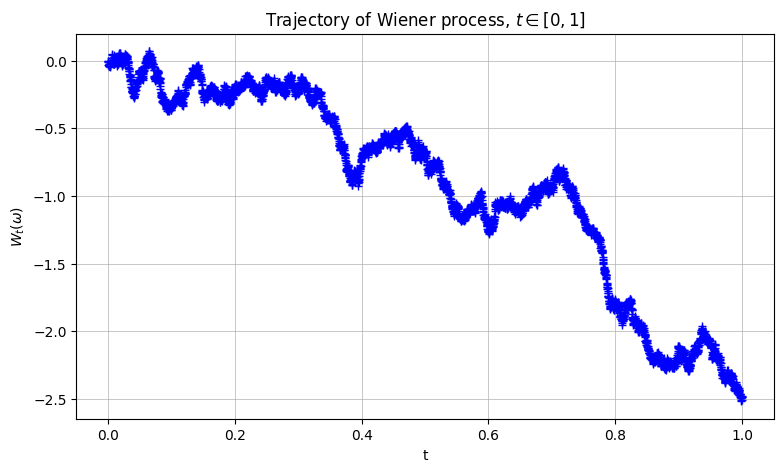

In [46]:
grid = np.linspace(0, 1, 2**depth + 1, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.plot(grid, wiener_trajectory, 'b+')

plt.title('Trajectory of Wiener process, $t\in[0,1]$')
plt.ylabel('$W_t(\omega)$')
plt.xlabel('t')
plt.show()

### Решение для процесса Орнштейна-Уленбека

Стационарность процесса Орнштейна-Уленбека влечёт
$$
R_X(s,t) = R_X(|s-t|),\forall s,t;\qquad \mathbb{E}X_t \equiv \mu;\qquad \mathbb{D}X_t \equiv \sigma^2.
$$
Следовательно, для корреляционной функции также выполнено $\widetilde{R}_X(s,t)=R_X(|s-t|)$.

Марковость процесса Орнштейна-Уленбека влечёт
$$
\widetilde{R}_X(s,t) = \widetilde{R}_X(s,\tau)\cdot \widetilde{R}_X(\tau,t),\quad\forall s<\tau<t.
$$
Значит, из марковости и стационарности:
$$
\widetilde{R}_X(|s-t|) = \widetilde{R}_X(|s-\tau|)\cdot \widetilde{R}_X(|\tau - t|), \quad\forall s<\tau<t.
$$


Обозначим $x=s-\tau, y=\tau-t$. Тогда
$$
\widetilde{R}_X(|x+y|) = \widetilde{R}_X(|x|)\cdot \widetilde{R}_X(|y|),
$$
т.е. корреляционная функция удовлетворяет функциональному уравнению Коши. Возможны два случая.

1. $\widetilde{R}_X(t)\equiv 0,~\forall t>0$.
2. $\widetilde{R}_X(t)\equiv e^{-\theta t}, \theta>0$.

Далее считаем, что корреляцияционная функция ненулевая (иначе моделирование сводится к моделированию независимых нормально распределенных случайных величин со средним $\mu$ и дисперсией $\sigma^2$).

Тогда ковариационная функция имеет вид
$$
R_X(t_1,t_2)=\sigma^2e^{-\theta|t_2-t_1|},\quad \theta>0.
$$

Таким образом, $X_t\sim\mathcal{N}(\mu,\sigma^2)$. \
Далее будем считать $\mu=0$ (этого легко можно добиться на практике, рассматривая процесс $X_t-\mu$).


В отличие от винеровского процесса, $X_0$ не является фиксированной величиной. \
Найдем распределение $Z = X_1|X_0$:
$$
p_Z(x; x_0) = \dfrac{p_{(X_0,X_1)}(x_0, x)}{p_{X_0}(x_0)}.
$$

В данном случае
$$
\begin{aligned}
p_{(X_0,X_1)}(x_0, x) &= \dfrac{1}{\sqrt{(2\pi)^2|\Sigma_{01}|}} \exp\left\{ -\dfrac{1}{2}(x_0, x)\Sigma_{01}^{-1}(x_0, x)^T \right\}. \\
\Sigma_{01} &= \{ R_X(i,j) \}_{i,j=0,1} = \sigma^2\begin{pmatrix}
1 & e^{-\theta} \\
e^{-\theta} & 1
\end{pmatrix}. \\
|\Sigma_{01}| &= \sigma^4(1-e^{-2\theta}). \\
\Sigma_{01}^{-1} &= \frac{\sigma^2}{\sigma^4(1-e^{-2\theta})}\begin{pmatrix}
1 & -e^{-\theta} \\
-e^{-\theta} & 1
\end{pmatrix}.
\end{aligned}
$$

Тогда
$$
\begin{aligned}
p_Z(x; x_0) &= \dfrac{1}{\sqrt{2\pi\sigma^2(1-e^{-2\theta})}}\exp\left\{
    -\dfrac{x_0^2 - 2x_0xe^{-\theta} + x^2}{2\sigma^2(1-e^{-2\theta})} + \dfrac{x_0^2}{2\sigma^2}
\right\} = \\
&= \dfrac{1}{\sqrt{2\pi\sigma^2(1-e^{-2\theta})}}\exp\left\{
    -\dfrac{(x-x_0e^{-\theta})^2}{2\sigma^2(1-e^{-2\theta})}
\right\}.
\end{aligned}
$$
Таким образом, $p_Z(x; x_0)\sim\mathcal{N}(x_0e^{-\theta},\sigma^2(1-e^{-2\theta}))$.

Аналогично прошлом пункту нас интересует распределение $Y = X_{t_3}|X_{t_1}=x_1,X_{t_2}=x_2$, где $t_3=\frac{t_1+t_2}{2}$.

Вычислим переходную плотность $p_Y(x;x_1,x_2) = p_Y(x ~|~ X_{t_1}=x_1, X_{t_2}=x_2)$:
$$
p_Y(x;x_1,x_2) = \dfrac{p_{(X_{t_1},X_{t_3},X_{t_2})}(x_1, x, x_2)}{p_{(X_{t_1},X_{t_2})}(x_1,x_2)}.
$$

Обозначим
$$
\begin{aligned}
\Sigma_{12} &= \{R_X(t_i,t_j) \}_{i,j=1,2} = \sigma^2\begin{pmatrix}
1 & e^{-\theta(t_2-t_1)} \\
e^{-\theta(t_2-t_1)} & 1
\end{pmatrix}, \\
\Sigma_{132} &= \sigma^2\begin{pmatrix}
1 & e^{-\theta(t_3-t_1)} & e^{-\theta(t_2-t_1)} \\
e^{-\theta(t_3-t_1)} & 1 & e^{-\theta(t_2-t_3)} \\
e^{-\theta(t_2-t_1)} & e^{-\theta(t_2-t_3)} & 1
\end{pmatrix}.
\end{aligned}
$$

Следовательно,
$$
p_{(X_{t_1},X_{t_3},X_{t_2})}(\omega_1,\omega,\omega_2) = \dfrac{1}{\sqrt{(2\pi)^3|\Sigma_{132}|}}
\exp\left\{ -\dfrac{1}{2} (x_1,x,x_2)\Sigma_{132}^{-1}(x_1,x,x_2)^T \right\}. \\
p_{(X_{t_1},X_{t_2})}(x_1,x_2) = \dfrac{1}{\sqrt{(2\pi)^2|\Sigma_{12}|}}
\exp\left\{ -\dfrac{1}{2}(x_1,x_2)\Sigma_{12}^{-1}(x_1,x_2)^T \right\}.
$$

In [47]:
x_1, x, x_2 = sym.symbols('x_1 x x_2', real=True)
h = sym.Symbol('h', real=True)
sigma = sym.symbols('sigma', real=True)
theta = sym.symbols('theta', real=True)
t_1, t_2, t_3 = sym.symbols('t_1 t_2 t_3', real=True)

t_3 = (t_1 + t_2) / 2

C12 = sigma ** 2 * sym.Matrix([
    [1, sym.exp(-theta * 2*h)],
    [sym.exp(-theta * 2*h), 1]
])
C132 = sigma ** 2 * sym.Matrix([
    [1, sym.exp(-theta * h), sym.exp(-theta * 2*h)],
    [sym.exp(-theta * h), 1, sym.exp(-theta * h)],
    [sym.exp(-theta * 2*h), sym.exp(-theta * h), 1]
])

vec_132 = sym.Matrix([x_1, x, x_2])
vec_12 = sym.Matrix([x_1, x_2])

In [48]:
new_sigma_2 = (C132.det() / C12.det()).simplify()
new_sigma_2

sigma**2*tanh(h*theta)

In [49]:
exp_factor = (-sym.Rational(1, 2) * vec_132.T @ C132.inv() @ vec_132)[0] + (sym.Rational(1, 2) * vec_12.T @ C12.inv() @ vec_12)[0]
exp_factor = exp_factor.simplify().factor()
exp_factor

-(x*exp(2*h*theta) + x - x_1*exp(h*theta) - x_2*exp(h*theta))**2/(2*sigma**2*(exp(h*theta) - 1)*(exp(h*theta) + 1)*(exp(2*h*theta) + 1))

Для удобства обозначим $h = t_3-t_1, 2h = t_2-t_1$ и
$$
\widetilde\sigma^2 = \dfrac{\sigma^2(e^{h\theta}-e^{-h\theta})}{e^{h\theta}+e^{-h\theta}} = \dfrac{\sigma^2(e^{2h\theta}-1)}{e^{2h\theta}+1}.
$$
Тогда
$$
-\dfrac{(x e^{2h\theta} + x - x_1e^{h\theta} - x_2e^{h\theta})^2}
{2\sigma^2(e^{h\theta}-1)(e^{h\theta}+1)(e^{2h\theta}+1)} = 
-\dfrac{(x - \frac{e^{h\theta}(x_1+x_2)}{e^{2h\theta}+1})^2}{2\widetilde\sigma^2}.
$$
Таким образом,
$$
p_Y(x;x_1,x_2) = \dfrac{1}{\sqrt{2\pi\widetilde\sigma^2}}\exp\left\{ -\dfrac{(x - \frac{e^{h\theta}(x_1+x_2)}{e^{2h\theta}+1})^2}{2\widetilde\sigma^2} \right\},
$$
т.е. $Y\sim\mathcal{N}\left( \dfrac{x_1+x_2}{e^{h\theta}+e^{-h\theta}}, \dfrac{\sigma^2(e^{h\theta}-e^{-h\theta})}{e^{h\theta}+e^{-h\theta}} \right)$.

In [61]:
def modelate_ornstein_uhlenbeck(depth=1, sigma=1.0, theta=1.0, x_0=0.0):
    """
    Modelate trajectory of Ornstein-Uhlenbeck process X_t(\omega),t\in[0,1]
    arguments:
        depth - depth of bisection
        sigma, theta - covariation parameteres
        x_0 - starting value
    returns vector of size 2^depth + 1
    """
    if not isinstance(depth, (int, np.integer)) or depth <= 0:
        raise ValueError('Depth must be a positive integer number.')
    if sigma <= 0:
        raise ValueError('Sigma must be a positive float number.')
    if theta < 0:
        raise ValueError('Theta must be a non-negative float number.')
    result = np.zeros(2 ** depth + 1)
    # modelate X_0 and X_1|X_0
    result[0] = x_0
    result[-1] = rand_norm(x_0 * np.exp(-theta), sigma * np.sqrt(1 - np.exp(-2*theta)))
    for k in range(1, depth+1):
        first = 2 ** (depth - k)            # first element to step from
        step = 2 ** (depth - k + 1)         # index step value
        h = 2 ** (-k)                       # t_2 - t_1
        for i in range(first, 2 ** depth + 1, step):
            x_1 = result[i - step//2]       # add a split at depth=k
            x_2 = result[i + step//2]
            loc = (x_1 + x_2) / (2 * np.cosh(h * theta))
            scale = sigma * np.sqrt(np.tanh(h * theta))
            result[i] = rand_norm(loc, scale)
    return result

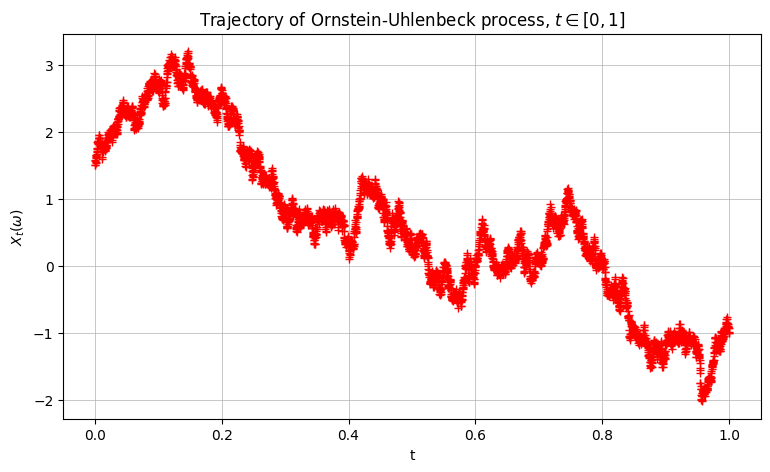

In [68]:
# modelate the process
depth = 12
sigma = 2.25
theta = 0.75
x_0 = 1.5
ornstein_uhlenbeck_trajectory = modelate_ornstein_uhlenbeck(depth, sigma, theta, x_0)

# plotting
grid = np.linspace(0, 1, 2**depth + 1, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.plot(grid, ornstein_uhlenbeck_trajectory, 'r+')

plt.title('Trajectory of Ornstein-Uhlenbeck process, $t\in[0,1]$')
plt.ylabel('$X_t(\omega)$')
plt.xlabel('t')
plt.show()

## Задание 10

### Условие

Произвести фильтрацию одномерного процесса Орнштейна-Уленбека:

1. Используя генетор белого шума, добавить к реализации процесса Орнштейна-Уленбека случайную ошибку с заранее известной дисперсией.

2. При помощи одномерного фильтра Калмана оценить траекторию процесса по зашумленному сигналу, считая известными параметры шума и процесса.

3. Рассмотреть следующие виды шума:
    1. Гауссов
    2. Коши (шум имеет распределение Коши)

### Теоретические выкладки

Рассмотрим дискретный одномерный фильтр Калмана для динамической системы вида:
$$
\begin{cases}
x_{n+1} = ax_n + \nu_n, \\
y_n = x_n + \varepsilon_n, \\
x_1 \sim \mathcal{N}(0,\sigma^2),
\end{cases}
$$
где 
- $\nu_n\sim\mathcal{N}(0,q)$ - н.о.р.с.в.; 
- $\varepsilon_n$ - шум, распределен как $\mathcal{N}(0,r)$ или $\mathcal{C}(0,r)$; 
- $r,\sigma^2 > 0$ - заданные параметры;
- $a,q$ - неизвестные величины.

Для определения коэффициентов уравнения динамики необходимо приравнять теоретические значения ковариационной матрицы процесса Орнштейна-Уленбека в
точках $t_n$ и $t_{n+1}$ c соответствующими значениями динамической системы, то есть решить систему уравнений относительно неизвестных коэффициентов $a$ и $q$ через известные $\sigma$ и $\theta$:
$$
\begin{cases}
R_X(t_n,t_n) = \sigma^2 = \mathbb{D}x_n, \\
R_X(t_n,t_{n+1}) = \sigma^2 e^{-\theta(t_{n+1}-t_n)} = \operatorname{cov}(x_n,x_{n+1}) = a\mathbb{D}x_n, \\
R_X(t_{n+1},t_{n+1}) = \sigma^2 = \mathbb{D}x_{n+1} = a^2 \mathbb{D}x_n + q.
\end{cases}
$$
При фильтрации значение оригинального процесса $x_n$ неизвестно. Вместо него доступен наблюдаемый зашумленный сигнал $y_n$.

Положим, что наблюдение происходит на равномерной сетке отрезка $[0,1]$ с шагом $h$. Тогда решением указанной системы является
$$
a = e^{-\theta h},\quad q = \sigma^2(1 - e^{-2\theta h}).
$$

При помощи фильтра Калмана будем оценивать траекторию зашумленного процесса $y_n$: построим доверительный интервал $[\hat x_n-k_\alpha R_n,\hat x_n-k_\alpha R_n]$

### Решение для гауссова шума

### Решение для шума с распределением Коши

## Задание 11

### Условие

Построить двумерное пуассоновское поле, отвечающее сложному пуассоновскому процессу:

1. Система массового обслуживания. Первая координата поля - время поступления заявки в СМО (распределение равномерно), а вторая - время обслуживания заявки (распределение $\chi^2$ с десятью степенями свободы).

2. Система массового обслуживания с циклической интенсивностью $\lambda(1+\cos(t))$ и единичными скачками. При помощи метода Льюиса и Шедлеара, свести задачу моделирования неоднородного пуассоновского процесса к моделированию двумерного пуассоновского поля, где первая координата распределена равномерно, а вторая имеет распределение Бернулли.

3. Работа страховой компании: первая координата - момент наступления страхового случая (равномерное распределение), вторая величина ущерба (распределение Парето). Поступление капитала считать линейным по времени со скоростью $c>0$, начальный капитал $W>0$.

## Список литературы

[1]. Бусленко Н.П., Голенко Д.И., Соболь И.М., Срагович В.Г., Шрейдер Ю.А. Метод статистических испытаний. Букинист, 1962.

[2] [Феллер В. Введение в теорию вероятностей и ее приложения, Том 1. М.: Мир, 1964.](https://ikfia.ysn.ru/wp-content/uploads/2018/01/Feller_t1_1964ru.pdf)

[3]. [Феллер В. Введение в теорию вероятностей и ее приложения, Том 2. М.: Мир, 1967.](https://ikfia.ysn.ru/wp-content/uploads/2018/01/Feller_t2_1967ru.pdf)